<a href="https://colab.research.google.com/github/pszemraj/pubmed-text-classification/blob/analysis/notebooks/colab/Convert_local_TensorBoard_data_%26_analyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convert local TensorBoard data.ipynb

In [1]:
%%capture
#@markdown set up auto-formatting of cells in notebook

from IPython.display import HTML, display


def set_css():
    display(
        HTML(
            """
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  """
        )
    )
get_ipython().events.register("pre_run_cell", set_css)

In [2]:
#@markdown setup logging
import logging
from pathlib import Path
das_logfile = Path.cwd() / "LOGFILE_tensorboard_converter.log"

logging.basicConfig(
    level=logging.INFO,
    filename=das_logfile,
    format="%(asctime)s %(levelname)s %(message)s",
    datefmt="%m/%d/%Y %I:%M:%S",
)
print(f'logfile is at:\n\n{das_logfile}')

logfile is at:

/content/LOGFILE_tensorboard_converter.log


## setup

In [3]:
!pip install -U pandas pyarrow -q
import pandas as pd

In [4]:
!pip install -U matplotlib -q
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline


In [1]:
# Requires the latest pip
!pip install --upgrade pip -q

# Current stable release for CPU and GPU
!pip install tensorflow tensorboard -q
!pip install -U pandas-profiling -q
!!pip install -U flaml -q

["\x1bWARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv\x1b\x1b",
 '\x1b']

In [7]:
from flaml import AutoML


TypeError: ignored

In [ ]:
#@title mount drive
from google.colab import drive
from pathlib import Path
drive_base_str = '/content/drive'
drive.mount(drive_base_str)


In [ ]:
from pathlib import Path
root_dir = "/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project2/transformers" #@param {type:"string"}
root_dir = Path(root_dir)

help_text = f"entered directory either does not exist or is not a directory. Received:\n\t{root_dir.resolve()}"
assert root_dir.exists() and root_dir.is_dir(), help_text

# find the subdirectories, of which logs are some
subdirs = {d.name:d for d in root_dir.iterdir() if d.is_dir()}
_found_subdirs = list(subdirs.keys())
print(f"found the following directories in the root:\n{_found_subdirs}")




In [ ]:
log_dir = "logs_pubmed_20k_no_freeze description" #@param ["logs_pubmed_20k", "logs_pubmed_full"] {allow-input: true}
assert log_dir in _found_subdirs, "log_dir must be a directory name inside root"

tensorboard_logpath = root_dir / log_dir

print(f"will extract files from\n\n:{tensorboard_logpath}")

# define function

In [ ]:
from datetime import datetime
import pprint as pp 
def get_timestamp():
    """get_timestamp - returns a timestamp in the format YYYY-MM-DD-HH-MM-SS"""
    return datetime.now().strftime("%b-%d-%Y_t-%H")

In [ ]:
def convert_tb_data(root_dir, sort_by="step"):
    """Convert local TensorBoard data into Pandas DataFrame.
    
    Function takes the root directory path and recursively parses
    all events data.    
    If the `sort_by` value is provided then it will use that column
    to sort values; typically `wall_time` or `step`.
    
    *Note* that the whole data is converted into a DataFrame.
    Depending on the data size this might take a while. If it takes
    too long then narrow it to some sub-directories.
    
    Paramters:
        root_dir: (str) path to root dir with tensorboard data.
        sort_by: (optional str) column name to sort by.
    
    Returns:
        pandas.DataFrame with [wall_time, name, step, value] columns.
    
    """
    import os
    import pandas as pd
    from tensorflow.python.summary.summary_iterator import summary_iterator
    from tqdm.auto import tqdm
    def convert_tfevent(filepath, log_examples=False):

        _f = Path(filepath)

        _df =  pd.DataFrame([
            parse_tfevent(e, log_examples) for e in summary_iterator(filepath) if len(e.summary.value)
        ])

        _df['version'] = _f.parent.name
        _df['model'] = _f.parent.parent.name
        _df['dataset'] = str(_f.parent.parent.parent.name).replace("logs_","")

        return _df
    
    def parse_tfevent(tfevent, log_examples=False):
        event_data = dict(
                        wall_time=tfevent.wall_time,
                        name=tfevent.summary.value[0].tag,
                        step=tfevent.step,
                        value=float(tfevent.summary.value[0].simple_value),
                    )
        if log_examples:
            logging.info(f"\n\nEvent data for example:\n\t{pp.pformat(event_data)}")
            logging.info(f"other fields:\t{pp.pformat(dir(tfevent))}")

        return event_data
    
    columns_order = ['dataset', 'model', 'version', 'wall_time', 'name', 'step', 'value']
    out = []
    for (root, _, filenames) in tqdm(os.walk(root_dir)):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            try:
                file_full_path = os.path.join(root, filename)
                out.append(convert_tfevent(file_full_path, log_examples=False))
            except Exception as e:
                logging.warning(f"unable to convert the event, error is: {e}")

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by is not None:
        all_df = all_df.sort_values(sort_by)
        
    return all_df.reset_index(drop=True)


In [ ]:
data_dir = "/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project2/transformers/tensorboard_data_processed_2100" #@param {type:"string"}
data_dir = Path(data_dir)

# extract 

In [ ]:
df = convert_tb_data(root_dir=tensorboard_logpath, sort_by="step").convert_dtypes()

df.head()

In [ ]:
df.info()

In [ ]:
gpu_stuff = [n for n in df.name.unique() if "device_id:" in n or "gpu_id:" in n]
misc_useless = ['hp_metric',         '_hparams_/experiment',
 '_hparams_/session_start_info',   '_hparams_/session_end_info',]
gpu_stuff.extend(misc_useless)
df_cln = df.drop(df[df.name.isin(gpu_stuff)].index)
len(df_cln)

In [ ]:
output_dir = root_dir / "tensorboard_data_processed"
output_dir.mkdir(exist_ok=True)

df_out = output_dir / f"tensorboard_training_logs_{log_dir}_{get_timestamp()}"

In [ ]:
df_cln.to_csv(df_out.with_suffix('.csv'), index=False)
df_cln.to_excel(df_out.with_suffix('.xlsx'), index=False)

df_out.with_suffix('.csv').resolve()

## re-combine individual dataframes

In [ ]:
def get_timestamp():
    return datetime.now().strftime("%b-%d_t-%H")

In [ ]:
files = {f for f in data_dir.iterdir() if f.is_file() and f.suffix=='.csv'}
study_df = pd.DataFrame()
for f in files:
    df = pd.read_csv(f).convert_dtypes()
    study_df = pd.concat([study_df, df], axis=0)
study_df.reset_index(drop=True, inplace=True)
study_df.info()

In [ ]:
study_df.head()

In [ ]:
agg_df_path = data_dir.parent / f"transformers_agg_train_data_raw_{get_timestamp()}"
study_df.to_csv(agg_df_path.with_suffix('.csv'), index=False)
study_df.to_excel(agg_df_path.with_suffix('.xlsx'), index=False)

agg_df_path.with_suffix('.csv').resolve()

In [ ]:
pp.pprint(study_df.model.unique())

## additional parsing

_some columns are actually multiple things and need to be unpacked:_ `txtcls_pubmed_20k_xtremedistil-l12-h384-uncased`


In [ ]:
load_for_parsing = "/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project2/transformers/tensorboard_logs2022-04-26_21-20.csv" #@param {type:"string"}
if len(load_for_parsing) > 2:
    load_for_parsing = Path(load_for_parsing)
    assert load_for_parsing.exists(), "input must exist"
    study_df = pd.read_csv(load_for_parsing
                           ).convert_dtypes()
else:
    print("not side-loading data in for parsing")

In [ ]:
def parse_modelcol(text:str):
    """
    splits this trash out:
        'txtcls_pubmed_20k_xtremedistil-l12-h384-uncased',
    'txtcls_pubmed_20k_bluebert_pubmed_uncased_L-12_H',
                    'txtcls_pubmed_20k_albert-large-v2',
    """
    modelcol = text.replace("-", "_")
    modelcol = modelcol.replace("txtcls_", "")

    if "pubmed_20k" in modelcol:
        dataset = "pubmed_20k"
        modelcol = modelcol.replace("pubmed_20k_", "")
    else:
        dataset = "pubmed_full"
        modelcol = modelcol.replace("pubmed_full_", "")


    return modelcol, dataset



parse_modelcol('txtcls_pubmed_20k_xtremedistil-l12-h384-uncased',)

('xtremedistil_l12_h384_uncased', 'pubmed_20k')

In [ ]:
pp.pprint(study_df.dataset.unique())


<StringArray>
[                     '20k_finetune',             'pubmed_20k_full_train',
                'pubmed_full_freeze',             'pubmed_full_no_freeze',
 'pubmed_full_no_freeze description',  'pubmed_20k_no_freeze description',
     'pubmed_20k_freeze description']
Length: 7, dtype: string


In [ ]:
def parse_datasetcol(text:str, verbose=False):
    """
    split the column dataset into multiple to avoid the messy aggregate

     '20k_finetune', 'pubmed_full_no_freeze description'
    """

    if verbose:
        print(f"input column value:\t{text}")
    if "20k" in text:
        # dataset = text.split("20k_", maxsplit=1)[0]
        dataset = 'pubmed_20k'
        train_method = text.split("20k_", maxsplit=1)[-1]
    else:
        # dataset = text.split("20k_", maxsplit=1)[0]
        dataset = 'pubmed_full'
        train_method = text.split("pubmed_full_", maxsplit=1)[-1]
    if ' description' in train_method:
        train_on_raw_data = True
        train_method = train_method.split(" ", maxsplit=1)[0]
    else:
        train_on_raw_data = False
        # nothing is appended in this case so no split required
    return dataset, train_method, train_on_raw_data

parse_datasetcol('pubmed_full_no_freeze description', True)

input column value:	pubmed_full_no_freeze description


('pubmed_full', 'no_freeze', True)

### iterate

In [ ]:
from tqdm.auto import tqdm

def parse_multicols(df):
    """
    applies the parse_datasetcol & parse_modelcol functions via df.iterrows()
    """
    parsed_df = df.copy(deep=True)
    parsed_df['tuning_strategy'] = ""
    parsed_df['train_on_raw_data'] = False
    for index, row in tqdm(parsed_df.iterrows(), total=len(parsed_df)):

        _model, _dataset = parse_modelcol(row['model'])
        _dataset_conf, _tune_strat, _raw_data = parse_datasetcol(row['dataset'])
        assert _dataset.strip() == _dataset_conf.strip(), "datasets for the same row parsed differently"
        parsed_df.loc[index, 'model'] = _model
        parsed_df.loc[index, 'dataset'] = _dataset
        parsed_df.loc[index, 'tuning_strategy'] = _tune_strat
        parsed_df.loc[index, 'train_on_raw_data'] = _raw_data

    parsed_df =  parsed_df.reset_index(drop=True).convert_dtypes()
    return parsed_df

def chunky_pandas(my_df, num_chunks: int = 4):
    """
    chunky_pandas [split dataframe into `num_chunks` equal chunks, return each inside a list]

    Args:
        my_df (pd.DataFrame)
        num_chunks (int, optional): Defaults to 4.

    Returns:
        list: a list of dataframes
    """
    n = int(len(my_df) // num_chunks)
    list_df = [my_df[i : i + n] for i in range(0, my_df.shape[0], n)]

    return list_df

In [ ]:
parse_multicols(study_df.head())

  0%|          | 0/5 [00:00<?, ?it/s]

,dataset,model,name,step,value,version,wall_time,tuning_strategy,train_on_raw_data
0,pubmed_20k,xtremedistil_l12_h384_uncased,lr-Adam,0,0.0001,version_3,1650574409.423172,finetune,False
1,pubmed_20k,xtremedistil_l12_h384_uncased,lr-Adam,0,0.0001,version_4,1650642827.059808,finetune,False
2,pubmed_20k,xtremedistil_l12_h384_uncased,lr-Adam,0,0.0001,version_0,1650561142.537016,finetune,False
3,pubmed_20k,xtremedistil_l12_h384_uncased,lr-Adam,0,0.0001,version_1,1650566381.383424,finetune,False
4,pubmed_20k,bluebert_pubmed_uncased_L_12_H,lr-Adam,0,0.0001,version_0,1650596887.148705,finetune,False


In [22]:
import os
from joblib import Parallel, delayed

parsed_df = study_df.copy(deep=True)

cpus = max(os.cpu_count(), 1)
split_data = chunky_pandas(parsed_df, num_chunks=cpus)
proc_split_dfs = Parallel(n_jobs=cpus, prefer="threads")(\
                    delayed(parse_multicols)(_df) for _df in split_data)

print(type(proc_split_dfs), len(proc_split_dfs))

  0%|          | 0/33885 [00:00<?, ?it/s]

  0%|          | 0/33885 [00:00<?, ?it/s]

  0%|          | 0/33885 [00:00<?, ?it/s]

  0%|          | 0/33885 [00:00<?, ?it/s]

  0%|          | 0/33885 [00:00<?, ?it/s]

  0%|          | 0/33885 [00:00<?, ?it/s]

  0%|          | 0/33885 [00:00<?, ?it/s]

  0%|          | 0/33885 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

<class 'list'> 9


In [23]:
proc_split_dfs[0]

,dataset,model,name,step,value,version,wall_time,tuning_strategy,train_on_raw_data
0,pubmed_20k,xtremedistil_l12_h384_uncased,lr-Adam,0,0.0001,version_3,1650574409.423172,finetune,False
1,pubmed_20k,xtremedistil_l12_h384_uncased,lr-Adam,0,0.0001,version_4,1650642827.059808,finetune,False
2,pubmed_20k,xtremedistil_l12_h384_uncased,lr-Adam,0,0.0001,version_0,1650561142.537016,finetune,False
3,pubmed_20k,xtremedistil_l12_h384_uncased,lr-Adam,0,0.0001,version_1,1650566381.383424,finetune,False
4,pubmed_20k,bluebert_pubmed_uncased_L_12_H,lr-Adam,0,0.0001,version_0,1650596887.148705,finetune,False
...,...,...,...,...,...,...,...,...,...
33880,pubmed_20k,albert_base_v2,train_accuracy_epoch,15465,0.719345,version_0,1650611853.212435,finetune,False
33881,pubmed_20k,bert_base_uncased,train_accuracy_epoch,15465,0.71036,version_0,1650628044.210453,finetune,False
33882,pubmed_20k,bert_base_uncased,train_matthewscorrcoef_epoch,15465,0.606176,version_0,1650628044.210535,finetune,False
33883,pubmed_20k,bert_base_uncased,train_f1score_epoch,15465,0.703829,version_0,1650628044.210567,finetune,False


In [24]:
reassembled_df = pd.DataFrame()
for _df in proc_split_dfs:
    reassembled_df = pd.concat([reassembled_df, _df], axis=0)
reassembled_df.reset_index(drop=True, inplace=True)
reassembled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271081 entries, 0 to 271080
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dataset            271081 non-null  string 
 1   model              271081 non-null  string 
 2   name               271081 non-null  string 
 3   step               271081 non-null  Int64  
 4   value              271081 non-null  Float64
 5   version            271081 non-null  string 
 6   wall_time          271081 non-null  Float64
 7   tuning_strategy    271081 non-null  string 
 8   train_on_raw_data  271081 non-null  boolean
dtypes: Float64(2), Int64(1), boolean(1), string(5)
memory usage: 17.8 MB


### export


In [37]:
export_reports = True #@param {type:"boolean"}
proc_df_path = data_dir.parent / f"trf_agg_train_data_processed_{get_timestamp()}"

if export_reports:
    reassembled_df.to_csv(proc_df_path.with_suffix('.csv'), index=False)
    reassembled_df.to_excel(proc_df_path.with_suffix('.xlsx'), index=False)

    proc_df_path.with_suffix('.csv').resolve()

In [38]:
reassembled_df.head()

,dataset,model,name,step,value,version,wall_time,tuning_strategy,train_on_raw_data
0,pubmed_20k,xtremedistil_l12_h384_uncased,lr-Adam,0,0.0001,version_3,1650574409.423172,finetune,False
1,pubmed_20k,xtremedistil_l12_h384_uncased,lr-Adam,0,0.0001,version_4,1650642827.059808,finetune,False
2,pubmed_20k,xtremedistil_l12_h384_uncased,lr-Adam,0,0.0001,version_0,1650561142.537016,finetune,False
3,pubmed_20k,xtremedistil_l12_h384_uncased,lr-Adam,0,0.0001,version_1,1650566381.383424,finetune,False
4,pubmed_20k,bluebert_pubmed_uncased_L_12_H,lr-Adam,0,0.0001,version_0,1650596887.148705,finetune,False


In [39]:
reassembled_df.model.value_counts()

bert_base_uncased                 43352
BiomedNLP_PubMedBERT_base_unca    38743
albert_base_v2                    35270
scibert_scivocab_uncased          28862
BioLinkBERT_base                  18869
xtremedistil_l12_h384_uncased     15659
bart_base                         13604
bluebert_pubmed_mimic_uncased_    11001
BioLinkBERT_large                 10260
scibert_scivocab_cased             9636
deberta_v3_small                   6311
bert_base_cased                    5745
BioM_ELECTRA_Base_Discriminato     5263
biobert_v1.1                       4843
bert_large_uncased                 3757
bioelectra_base_discriminator_     3757
diffcse_bert_base_uncased_tran     3600
BioM_BERT_PubMed_PMC_Large         3378
bluebert_pubmed_uncased_L_12_H     2739
LinkBERT_base                      2101
BiomedNLP_KRISSBERT_PubMed_UML     1526
deberta_v3_base                     912
specter                             522
bart_large                          488
Clinical_BigBird                    350


# analysis

In [40]:
pp.pprint(reassembled_df.name.unique())

<StringArray>
[                     'lr-Adam',           'train_f1score_step',
  'train_matthewscorrcoef_step',          'train_accuracy_step',
     'train_cross_entropy_step',                        'epoch',
         'train_accuracy_epoch',          'train_f1score_epoch',
 'train_matthewscorrcoef_epoch',    'train_cross_entropy_epoch',
            'val_cross_entropy',                  'val_f1score',
         'val_matthewscorrcoef',                 'val_accuracy',
           'test_cross_entropy',                 'test_f1score',
        'test_matthewscorrcoef',                'test_accuracy']
Length: 18, dtype: string


In [41]:
len(reassembled_df)

271081

In [42]:
list(reassembled_df.columns)

['dataset',
 'model',
 'name',
 'step',
 'value',
 'version',
 'wall_time',
 'tuning_strategy',
 'train_on_raw_data']

## wide DF

In [43]:
wide_df = reassembled_df.reset_index().pivot_table(values='value',
                                         index=['dataset', 'tuning_strategy',
 'train_on_raw_data','model', 'version', 'step'],
                                         columns='name', 
                                         aggfunc='mean').reset_index().convert_dtypes()
wide_df

,dataset,tuning_strategy,train_on_raw_data,model,version,step,epoch,lr-Adam,test_accuracy,test_cross_entropy,...,train_cross_entropy_epoch,train_cross_entropy_step,train_f1score_epoch,train_f1score_step,train_matthewscorrcoef_epoch,train_matthewscorrcoef_step,val_accuracy,val_cross_entropy,val_f1score,val_matthewscorrcoef
0,pubmed_20k,finetune,False,BioLinkBERT_base,version_0,0,<NA>,0.001,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,pubmed_20k,finetune,False,BioLinkBERT_base,version_0,49,0.0,<NA>,<NA>,<NA>,...,<NA>,1.071384,<NA>,0.560322,<NA>,0.436718,<NA>,<NA>,<NA>,<NA>
2,pubmed_20k,finetune,False,BioLinkBERT_base,version_0,99,0.0,<NA>,<NA>,<NA>,...,<NA>,1.111046,<NA>,0.499986,<NA>,0.413731,<NA>,<NA>,<NA>,<NA>
3,pubmed_20k,finetune,False,BioLinkBERT_base,version_0,149,0.0,<NA>,<NA>,<NA>,...,<NA>,0.996228,<NA>,0.544665,<NA>,0.419113,<NA>,<NA>,<NA>,<NA>
4,pubmed_20k,finetune,False,BioLinkBERT_base,version_0,199,0.0,<NA>,<NA>,<NA>,...,<NA>,1.023739,<NA>,0.593568,<NA>,0.442292,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54149,pubmed_full,no_freeze,True,bert_base_uncased,version_0,103099,1.0,<NA>,<NA>,<NA>,...,<NA>,0.789859,<NA>,0.755036,<NA>,0.680602,<NA>,<NA>,<NA>,<NA>
54150,pubmed_full,no_freeze,True,bert_base_uncased,version_0,103149,1.0,<NA>,<NA>,<NA>,...,<NA>,0.685005,<NA>,0.788165,<NA>,0.745959,<NA>,<NA>,<NA>,<NA>
54151,pubmed_full,no_freeze,True,bert_base_uncased,version_0,103199,1.0,<NA>,<NA>,<NA>,...,<NA>,0.620316,<NA>,0.760056,<NA>,0.694126,<NA>,<NA>,<NA>,<NA>
54152,pubmed_full,no_freeze,True,bert_base_uncased,version_0,103249,1.0,<NA>,<NA>,<NA>,...,<NA>,0.811007,<NA>,0.722676,<NA>,0.675511,<NA>,<NA>,<NA>,<NA>


In [44]:
wide_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54154 entries, 0 to 54153
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   dataset                       54154 non-null  string 
 1   tuning_strategy               54154 non-null  string 
 2   train_on_raw_data             54154 non-null  boolean
 3   model                         54154 non-null  string 
 4   version                       54154 non-null  string 
 5   step                          54154 non-null  Int64  
 6   epoch                         53689 non-null  Float64
 7   lr-Adam                       466 non-null    Float64
 8   test_accuracy                 47 non-null     Float64
 9   test_cross_entropy            47 non-null     Float64
 10  test_f1score                  47 non-null     Float64
 11  test_matthewscorrcoef         47 non-null     Float64
 12  train_accuracy_epoch          434 non-null    Float64
 13  t

In [45]:
#@markdown export wide dataframe
wide_df_path = data_dir.parent / f"trf_agg_train_data_processed_WIDE_{get_timestamp()}"
if export_reports:
    wide_df.to_csv(wide_df_path.with_suffix('.csv'), index=False)
    wide_df.to_excel(wide_df_path.with_suffix('.xlsx'), index=False)

    wide_df_path.with_suffix('.csv').resolve()
else:
    print("export set to false")

## test set data

In [46]:
test_df_long = reassembled_df[reassembled_df.name.isin(['test_f1score', 'epoch',  'test_cross_entropy'])]
test_df = test_df_long.reset_index().pivot_table(values='value',
                                                 index=['dataset', 'tuning_strategy',
                                    'train_on_raw_data','model', 'version', 'step'],
                                         columns='name', 
                                         aggfunc='mean').reset_index().convert_dtypes()
test_df.dropna(subset=['test_f1score'], inplace=True)
test_df = test_df.reset_index(drop=True).convert_dtypes()
test_df

,dataset,tuning_strategy,train_on_raw_data,model,version,step,epoch,test_cross_entropy,test_f1score
0,pubmed_20k,finetune,False,BioLinkBERT_base,version_0,22504,7.0,0.54521,0.796551
1,pubmed_20k,finetune,False,BioLinkBERT_base,version_4,39382,13.0,0.543518,0.796978
2,pubmed_20k,finetune,False,BioLinkBERT_base,version_6,101268,17.0,0.573967,0.789063
3,pubmed_20k,finetune,False,BioLinkBERT_base,version_8,19593,13.0,0.606767,0.781791
4,pubmed_20k,finetune,False,BioLinkBERT_large,version_4,101557,9.0,0.718113,0.733572
5,pubmed_20k,finetune,False,BioM_BERT_PubMed_PMC_Large,version_0,4352,5.0,0.454588,0.837538
6,pubmed_20k,finetune,False,BioM_ELECTRA_Base_Discriminato,version_0,11248,15.0,0.516567,0.811391
7,pubmed_20k,finetune,False,BiomedNLP_KRISSBERT_PubMed_UML,version_0,14116,10.0,0.613127,0.776614
8,pubmed_20k,finetune,False,BiomedNLP_PubMedBERT_base_unca,version_0,47658,4.0,0.376976,0.861355
9,pubmed_20k,finetune,False,Clinical_BigBird,version_0,3017,3.0,0.627977,0.770605


In [47]:
#@markdown export test set dataframe
test_df_path = data_dir.parent / f"transformers_test_set_summary_{get_timestamp()}"

if export_reports:
    test_df.to_csv(test_df_path.with_suffix('.csv'), index=False)
    test_df.to_excel(test_df_path.with_suffix('.xlsx'), index=False)

    test_df_path.with_suffix('.csv').resolve()
else:
    print("export reports set to false")

## Visualization

In [41]:

sideload_path = "/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project2/transformers/transformers_test_set_summary_Apr-26-2022_t-20.csv" #@param {type:"string"}
sideload_path = Path(sideload_path)

if len(str(sideload_path.resolve())) > 2:
    assert sideload_path.exists(), "sideload path needs to exist" 

### autoviz

In [42]:
!pip install -U -q autoviz

In [43]:
from autoviz.AutoViz_Class import AutoViz_Class

AV = AutoViz_Class()

In [44]:
viz_dir = data_dir.parent / 'reports and figures'
viz_dir.mkdir(exist_ok=True)


In [45]:
sep = ","
dft = AV.AutoViz(
    filename=str(sideload_path.with_suffix('.csv').resolve()),
    sep=",",
    depVar="test_f1score",
    dfte=None,
    header=0,
    verbose=1,
    lowess=False,
    chart_format="html",
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
    save_plot_dir=str(viz_dir.resolve())
)

Shape of your Data Set loaded: (47, 9)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  2
    Number of Integer-Categorical Columns =  1
    Number of String-Categorical Columns =  3
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  2
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    8 Predictors classified...
        No variables removed since no ID or low-information variables found in data set

################ Regression VISUALIZATION Started #####################
Data Set Shape: 47 rows, 9 cols
Data Set columns info:
* dataset: 0 nulls, 2 unique vals, most common: {'pubmed_20k': 42, 'pubmed_full': 5}
* tuning_strategy: 0 nulls, 4 unique vals, most common: {'finetune': 2

### pandas-profiling

In [46]:
df = pd.read_csv(sideload_path.with_suffix('.csv')).convert_dtypes()

In [47]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport


In [48]:
profile = ProfileReport(df, title=f"{log_dir} - Test Set Report",
                        explorative=True, dark_mode=True)

OSError: ignored

In [ ]:
profile.to_notebook_iframe()


In [ ]:
profile.to_file(viz_dir / f"transformers_test_set_EDA_pandas-profiling.html")

### sweetviz

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dataset             47 non-null     string 
 1   tuning_strategy     47 non-null     string 
 2   train_on_raw_data   47 non-null     boolean
 3   model               47 non-null     string 
 4   version             47 non-null     string 
 5   step                47 non-null     Int64  
 6   epoch               47 non-null     Int64  
 7   test_cross_entropy  47 non-null     Float64
 8   test_f1score        47 non-null     Float64
dtypes: Float64(2), Int64(2), boolean(1), string(4)
memory usage: 3.3 KB


In [50]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
len(df)

47

In [51]:
df.test_f1score = df.test_f1score.astype(float)
df.step = df.step.astype(int)
df.epoch = df.epoch.astype(int)

In [52]:
!pip install -U sweetviz -q

In [53]:
import sweetviz as sv

feature_config = sv.FeatureConfig(skip=["test_cross_entropy"], 
                                  force_cat=['model'],
                                  force_num=["epoch", "step"])
my_report = sv.analyze(df, target_feat="test_f1score", 
                       feat_cfg=feature_config,)

                                             |          | [  0%]   00:00 -> (? left)

In [54]:
sv_rep_path =  viz_dir / 'transformers_test_set_EDA_SweetVizEDA.html'
my_report.show_html( 
    filepath=str(sv_rep_path.resolve()), 
    open_browser=True, 
    layout='vertical', 
    scale=0.9,
)


Report /content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project2/transformers/reports and figures/transformers_test_set_EDA_SweetVizEDA.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## AutoML


- [FLAML](https://www.microsoft.com/en-us/research/project/flaml/articles/flaml-a-fast-and-lightweight-automl-library/) is a lightweight lib for autoML. here it is being used just to get a relative guage on feature importance (vs. just looking at plots)
- https://microsoft.github.io/FLAML/docs/Getting-Started
- https://github.com/microsoft/FLAML



In [55]:
automl = AutoML()
from flaml.model import LGBMEstimator, XGBoostEstimator

automl.add_learner("mylgbm", LGBMEstimator)
automl.add_learner("papa_boost", XGBoostEstimator)


cols = list(df.columns)
pred_col = 'test_f1score'
logname = "pubmed_test.log"
y_train = df[pred_col].values   
cols.remove(pred_col)
cols.remove('test_cross_entropy')
X_train = df[cols].values

# TODO: try to_numpy()
settings = {
    "time_budget": 300,  # in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['lgbm'],  # list of ML learners; we tune lightgbm in this example
    "task": 'regression',  # task type    
    "log_file_name": logname,
}


In [56]:
# automl.fit(X_train, y_train, time_budget=600, task="regression")
import os
automl.fit(X_train, y_train, 
           auto_augment=True,
           **settings,
           verbose=False,
           early_stop=True,
)

In [57]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 5, 'num_leaves': 13, 'min_child_samples': 5, 'learning_rate': 1.0, 'log_max_bin': 5, 'colsample_bytree': 0.5857883397050255, 'reg_alpha': 0.002877590364407366, 'reg_lambda': 0.6096613974303785}
Best accuracy on validation data: 0.5096
Training duration of best run: 0.01042 s


In [58]:
print(automl.model)

In [59]:
automl.best_result

{'config': {'colsample_bytree': 0.5857883397050255,
  'learning_rate': 1.0,
  'log_max_bin': 5,
  'min_child_samples': 5,
  'n_estimators': 5,
  'num_leaves': 13,
  'reg_alpha': 0.002877590364407366,
  'reg_lambda': 0.6096613974303785},
 'config/colsample_bytree': 0.5857883397050255,
 'config/learning_rate': 1.0,
 'config/log_max_bin': 5,
 'config/min_child_samples': 5,
 'config/n_estimators': 5,
 'config/num_leaves': 13,
 'config/reg_alpha': 0.002877590364407366,
 'config/reg_lambda': 0.6096613974303785,
 'experiment_tag': 'exp',
 'metric_for_logging': None,
 'pred_time': 0.000526182386610243,
 'time_total_s': 0.06745123863220215,
 'training_iteration': 1,
 'val_loss': 0.4904360368128134,
 'wall_clock_time': 267.7277035713196}

##save predictor for later

In [60]:
'''pickle and save the automl object'''

pred_col = 'test_f1score'
logname = "pubmed_test.log"

model_dir = viz_dir / "models_feat_importance"
model_dir.mkdir(exist_ok=True)
_m_path = model_dir / f"automl_feat_importance_{pred_col}_{logname.split('.')[0]}.pkl"
import pickle
with open(_m_path, 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open(_m_path, 'rb') as f:
    automl = pickle.load(f)

In [61]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)

In [62]:
%matplotlib inline

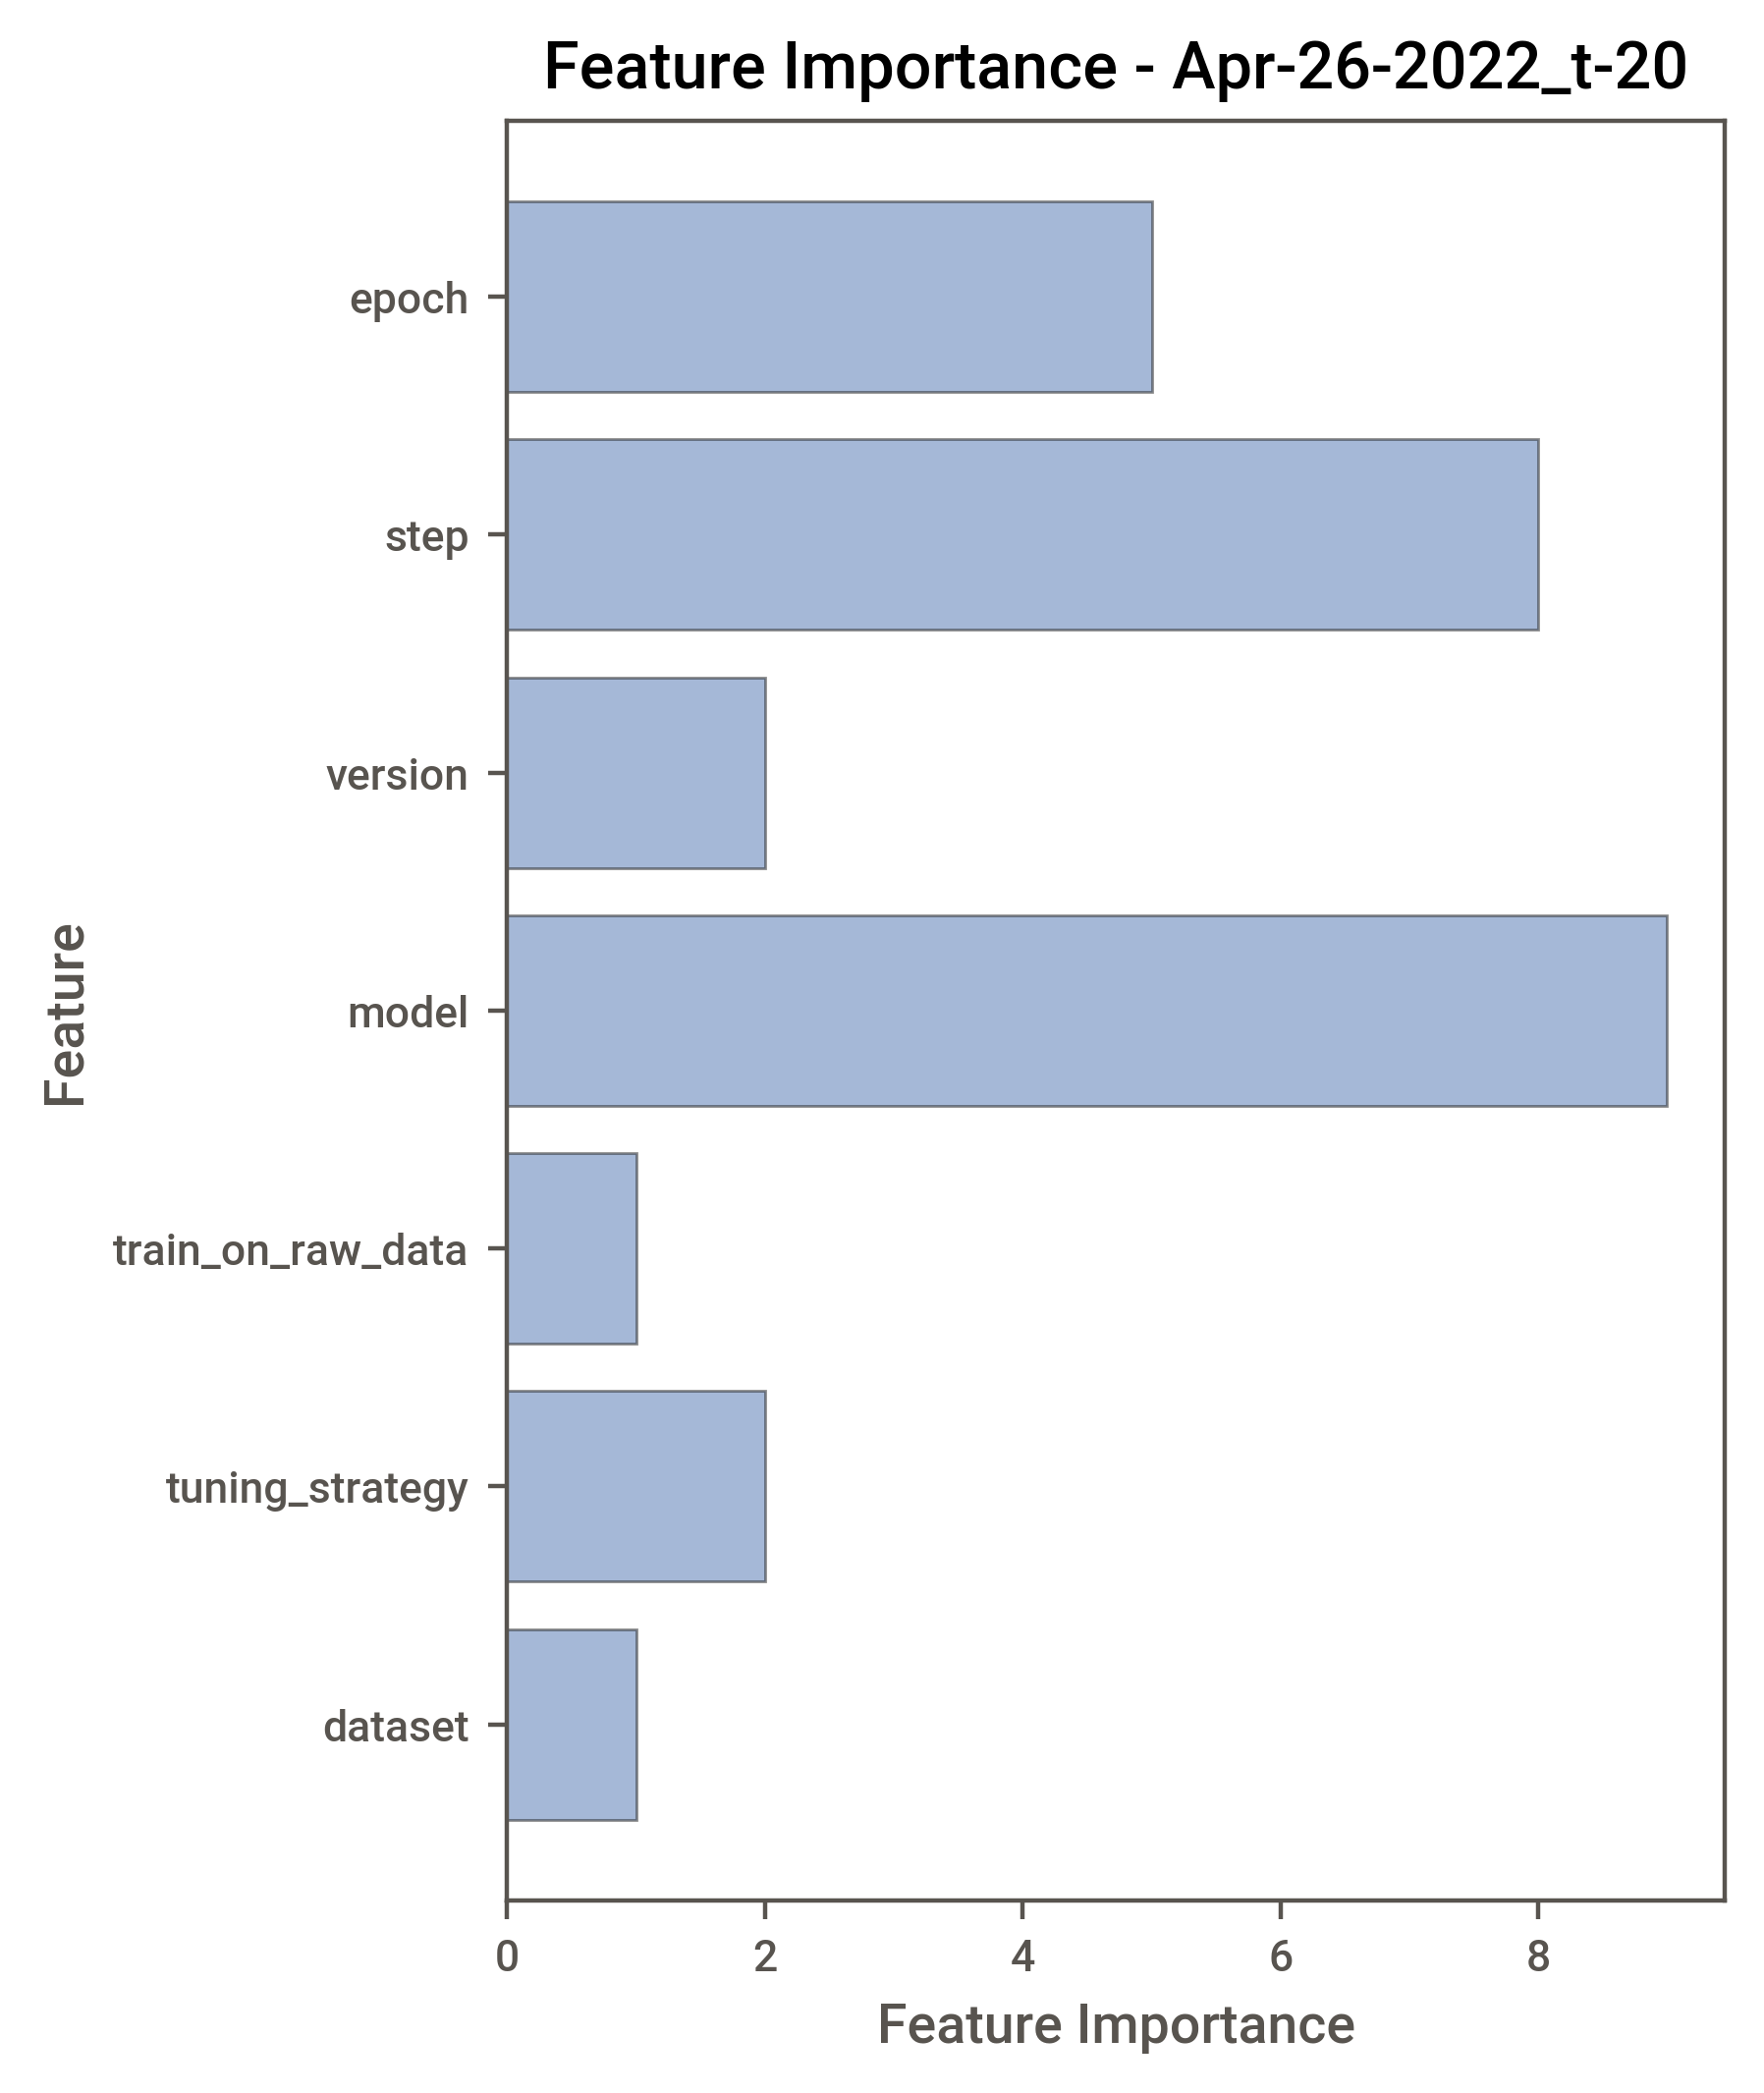

In [63]:
import matplotlib.pyplot as plt


# plt.barh(df[cols].columns, automl.model.estimator.feature_importances_)

fig = plt.figure(
    figsize=(4, 6), dpi=400,
)
plt.barh(
    df[cols].columns,
    automl.model.estimator.feature_importances_,
    color="b",
    align="center",
    alpha=0.5,
    edgecolor="k",
    linewidth=0.5,
    tick_label=df[cols].columns,
)

# add xlabel and ylabel and title
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"Feature Importance - {get_timestamp()}")
plt.savefig(model_dir / f"feature_importance_{get_timestamp()}.png", dpi=300, bbox_inches="tight")
plt.show()

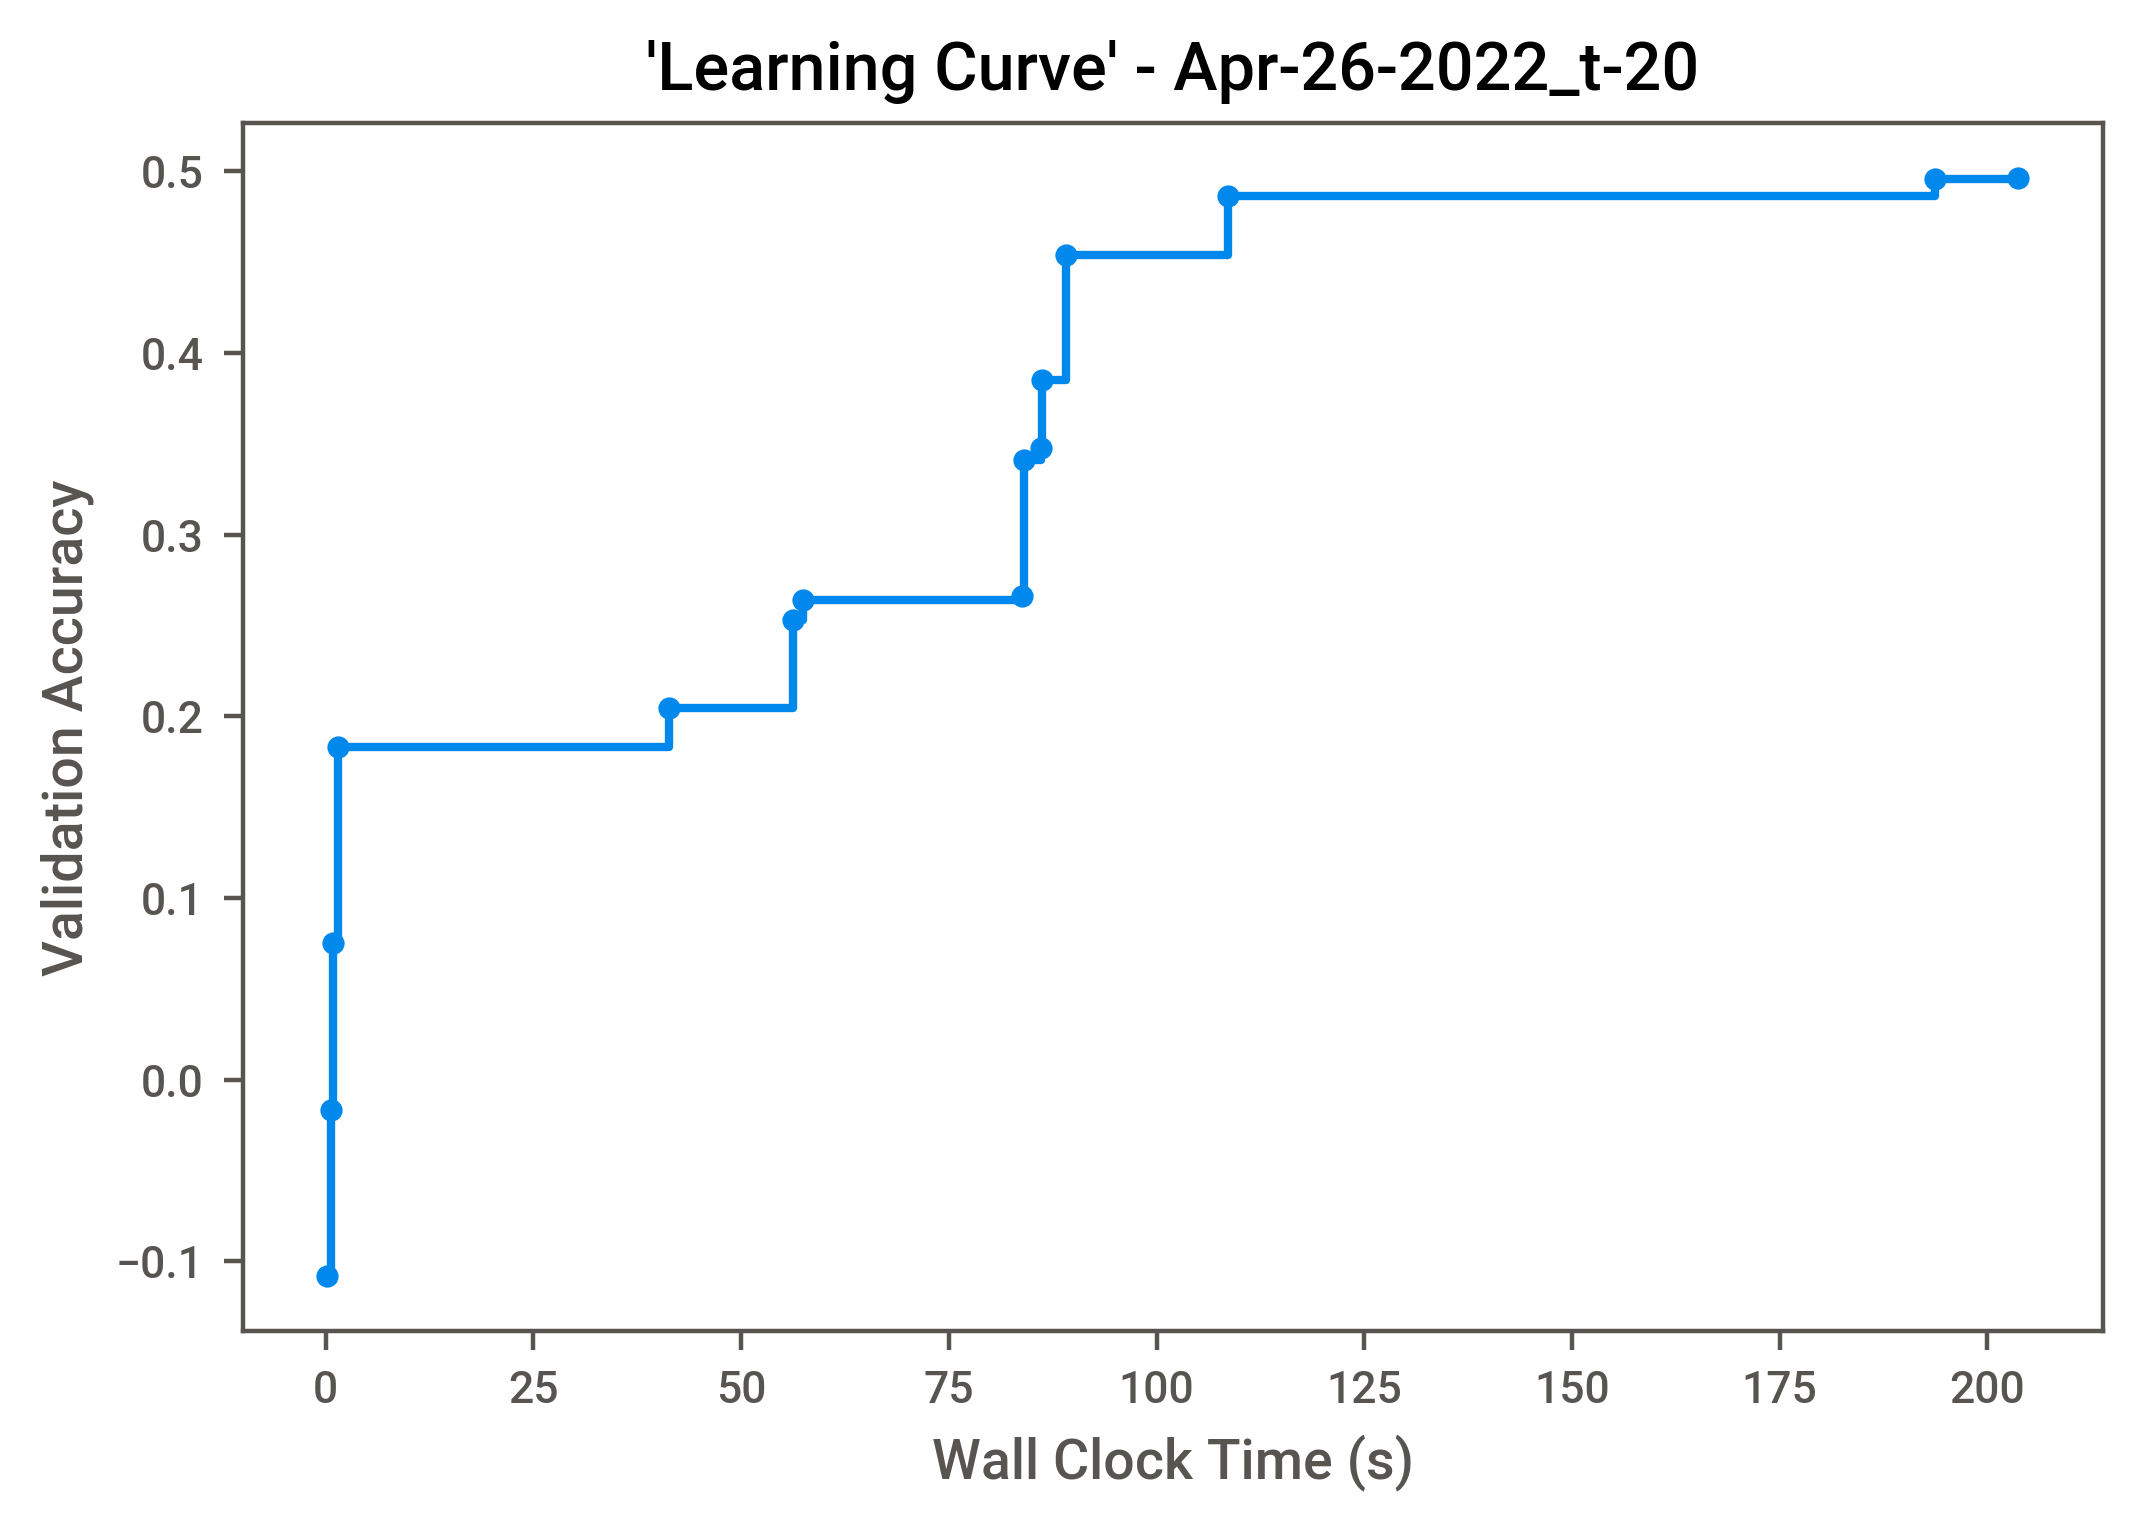

In [64]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(
    figsize=(6, 4), dpi=400,
)
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.title(f"'Learning Curve' - {get_timestamp()}")
plt.savefig(model_dir / f"'Learning Curve'{get_timestamp()}.png", dpi=300, bbox_inches="tight")
plt.show()

# New Section